In [1]:
import numpy as np
import math
import random
from tqdm.auto import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import keras
from keras.layers import Conv2D, Dense, Dropout, Input, Concatenate, GlobalMaxPooling1D, MaxPooling2D, Flatten
from keras.models import Model, Sequential
from keras import backend as K
#K.set_image_dim_ordering('th')

Using TensorFlow backend.


In [2]:
def load_data_splits(base_path='C:\\Users\\dylin\\Documents\\BA_Glare_Effect\\classification_data_initial\\features\\', splits=20):
    real_data_splits_train = []
    real_data_splits_test = []
    simulated_data_splits_train = []
    for split in range(1, splits + 1):
        # Real data for training
        X_realData_train = np.load(base_path + 'real\\Split%s\\for_simulation\\X_realData_train.npy' %str(split))
        y_realData_train = np.load(base_path + 'real\\Split%s\\for_simulation\\y_realData_train.npy' %str(split))
        real_data_splits_train.append((X_realData_train, y_realData_train))
        
        # Real data for testing
        X_realData_test = np.load(base_path + 'real\\Split%s\\for_testing\\X_realData_test.npy' %str(split))
        y_realData_test = np.load(base_path + 'real\\Split%s\\for_testing\\y_realData_test.npy' %str(split))
        real_data_splits_test.append((X_realData_test, y_realData_test))
    
        # Simulated data for training
        X_simulatedData_train = np.load(base_path + 'simulated\\Split%s\\X_simulatedData_train.npy' %str(split))
        y_simulatedData_train = np.load(base_path + 'simulated\\Split%s\\y_simulatedData_train.npy' %str(split))
        simulated_data_splits_train.append((X_simulatedData_train, y_simulatedData_train))
    return real_data_splits_train, real_data_splits_test, simulated_data_splits_train

In [3]:
real_data_splits_train, real_data_splits_test, simulated_data_splits_train = load_data_splits()

In [4]:
real_data_split_train, real_data_split_test, simulated_data_split_train = \
    real_data_splits_train[0], real_data_splits_test[0], simulated_data_splits_train[0]

In [5]:
real_data_split_train[1].shape

(38, 2)

In [6]:
def create_image(game, components=[True, True, True, True, True]):
    card_codes = np.zeros((7, 40))
    cards_left = np.zeros((8, 40))
    never_revealed_cards = np.zeros((14, 40))
    max_same_card_reveals = np.zeros((20, 40))
    rounds_since_done = np.zeros((27, 40))
    
    x_position = 0
    
    for step in game:
        card_code = math.floor(step[0])
        first_or_second = int(round((step[0] % 1) * 10))
        
        if card_code != 0:
            card_codes[card_code - 1][x_position] = first_or_second
            
        cards_left[int(step[1] / 2)][x_position] = 1
        never_revealed_cards[int(step[2])][x_position] = 1
        max_same_card_reveals[int(step[3])][x_position] = 1
        rounds_since_done[int(step[4])][x_position] = 1
        
        x_position += 1
        
    # Try leaving out some features and compare results!
    image = np.zeros((0, 40))
    if components[0]:   # Good visual feature for cnn.
        image = np.vstack((image, card_codes))
    if components[1]:
        image = np.vstack((image, max_same_card_reveals))
    if components[2]:   # I think good visual feature for cnn. 
        image = np.vstack((image, rounds_since_done))
    if components[3]:
        image = np.vstack((image, cards_left))
    if components[4]:   # I think this feature is not very usefull for the cnn. 
                        # No big visual difference between being blinded an not. 
        image = np.vstack((image, never_revealed_cards))
    #switched order of statistival features so that they have some space between them.
        
    return image#[::-1]


In [7]:
def create_images_for_split(data, components):
    data_images = []
    for split in trange(len(data)):
        X = data[split][0]
        y = data[split][1]
        images = []
        for game in range(len(X)):
            image = create_image(X[game], components)
            images.append(image)
        split_data = ((images, y))
        data_images.append(split_data)
    return data_images
    
def create_images(components=[True, True, True, True, True]):
    real_data_splits_train_images = create_images_for_split(real_data_splits_train, components)
    real_data_splits_test_images = create_images_for_split(real_data_splits_test, components)
    simulated_data_splits_train_images = create_images_for_split(simulated_data_splits_train, components)
    return real_data_splits_train_images, real_data_splits_test_images, simulated_data_splits_train_images 
    #return real_data_splits_train_images[0][0][24]

In [8]:
real_data_splits_train_images, real_data_splits_test_images, simulated_data_splits_train_images = \
    create_images(components=[True, True, True, True, True])

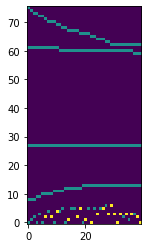

In [9]:
# Unclear noObst indices: 8?, 12
# Unclear glare indices: 23, 26?, 27, 32, 36, 
# Not cortrect validated: glare in split 1, 
# Plan: remove and train best conigs and see if results get better 

plt.imshow(real_data_splits_train_images[0][0][19], origin='lower') 

In [10]:
real_data_splits_train[0][1]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [11]:
real_data_splits_test

[(array([[[ 1.1, 14. , 13. ,  1. ,  0. ],
          [ 1.2, 12. , 12. ,  1. ,  0. ],
          [ 2.1, 12. , 11. ,  1. ,  0. ],
          [ 3.1, 12. , 10. ,  1. ,  0. ],
          [ 4.1, 12. ,  9. ,  1. ,  0. ],
          [ 5.1, 12. ,  8. ,  1. ,  0. ],
          [ 5.2, 12. ,  7. ,  1. ,  0. ],
          [ 5.1, 10. ,  7. ,  2. ,  0. ],
          [ 6.1, 10. ,  6. ,  2. ,  0. ],
          [ 3.2, 10. ,  5. ,  2. ,  0. ],
          [ 3.1, 10. ,  5. ,  2. ,  0. ],
          [ 3.2,  8. ,  5. ,  2. ,  0. ],
          [ 6.2,  8. ,  4. ,  2. ,  0. ],
          [ 4.1,  8. ,  4. ,  2. ,  0. ],
          [ 2.2,  8. ,  3. ,  2. ,  0. ],
          [ 2.1,  6. ,  3. ,  2. ,  0. ],
          [ 7.1,  6. ,  2. ,  2. ,  0. ],
          [ 7.2,  4. ,  1. ,  2. ,  0. ],
          [ 4.2,  4. ,  0. ,  2. ,  0. ],
          [ 6.1,  4. ,  0. ,  2. ,  0. ],
          [ 4.1,  4. ,  0. ,  3. ,  0. ],
          [ 4.2,  2. ,  0. ,  3. ,  0. ],
          [ 6.2,  2. ,  0. ,  3. ,  0. ],
          [ 6.1,  0. ,  0. ,  3. ,

In [12]:
n_participants_per_split = 19 # 20 but one is removed in each split for testing
simulations_per_participant = 1000
n_added_simulations_per_participant = 0
n_runs = 1
n_epochs = 1000

In [13]:
def add_simulated_data(X_train, y_train, simulated_train_set):
    for n in range(n_added_simulations_per_participant):
        for i in range(n_participants_per_split):

            X_train_simulated_1 = simulated_train_set[0][(i * simulations_per_participant) + n]
            y_train_simulated_1 = simulated_train_set[1][(i * simulations_per_participant) + n]
            X_train_simulated_2 = simulated_train_set[0][(simulations_per_participant * n_participants_per_split) \
                                                         + (i * simulations_per_participant) + n]
            y_train_simulated_2 = simulated_train_set[1][(simulations_per_participant * n_participants_per_split) \
                                                         + (i * simulations_per_participant) + n]
            
            X_train_simulated = np.concatenate((X_train_simulated_1[np.newaxis, :, :], \
                                               X_train_simulated_2[np.newaxis, :, :]), axis=0)
            y_train_simulated = np.concatenate((y_train_simulated_1[np.newaxis, :], \
                                               y_train_simulated_2[np.newaxis, :]), axis=0)

            X_train = np.concatenate((X_train, X_train_simulated), axis=0)
            y_train = np.concatenate((y_train, y_train_simulated), axis=0)
    return X_train, y_train

In [14]:
def mean_score_of_run(histories, epochs):
    mean_val_losses = []
    mean_val_accuracies = []
    mean_losses = []
    mean_accuracies = []
    for i in range(epochs):
        val_losses = []
        val_accuracies = []
        losses = []
        accuracies = []
        for l in range(len(histories)):
            history = histories[l]
            val_losses.append(history.history['val_loss'][i])
            val_accuracies.append(history.history['val_accuracy'][i])
            losses.append(history.history['loss'][i])
            accuracies.append(history.history['accuracy'][i])
        mean_val_losses.append(np.mean(val_losses))
        mean_val_accuracies.append(np.mean(val_accuracies))
        mean_losses.append(np.mean(losses))
        mean_accuracies.append(np.mean(accuracies))
    return mean_val_losses, mean_val_accuracies, mean_losses, mean_accuracies

In [15]:
def mean_score_over_all_runs(mean_run_scores, n_runs):
    val_losses = np.asarray(mean_run_scores[0][0])
    val_accuracies = np.asarray(mean_run_scores[0][1])
    losses = np.asarray(mean_run_scores[0][2])
    accuracies = np.asarray(mean_run_scores[0][3])
                            
    for i in range(1, n_runs):
        val_losses += np.asarray(mean_run_scores[i][0])
        val_accuracies += np.asarray(mean_run_scores[i][1])
        losses += np.asarray(mean_run_scores[i][2])
        accuracies += np.asarray(mean_run_scores[i][3])
                                 
    val_losses /= n_runs
    val_accuracies /= n_runs
    losses /= n_runs
    accuracies /= n_runs
    
    return val_losses, val_accuracies, losses, accuracies

In [16]:
opt = keras.optimizers.Adam(learning_rate=0.00001)

In [17]:
def create_and_train(X_train, y_train, X_test, y_test):
    X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
    X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
    cnn_input_shape = X_train[0].shape
    
    #epochs = n_epochs
    cnn_batch_size = 32 #1000
    #verbose = 0
    
    #print(cnn_input_shape)
    
    model = Sequential()
    model.add(Conv2D(64, (5, 5), input_shape=(76, 40,1), activation='relu'))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    #model.add(Conv2D(10, (2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))#, padding='same'))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=cnn_batch_size, verbose=1, 
                        shuffle=True, validation_data=(X_test, y_test))
    
    #print(history.history['val_accuracy'])
    #print(model.summary())
    
    histories.append(history)
    return model

In [18]:
model = None
mean_run_scores = []
for i in trange(n_runs, desc='Runs'): 
    histories = []
    
    data = list((zip(real_data_splits_train_images, \
                                    real_data_splits_test_images, simulated_data_splits_train_images)))[0]
    train_set, test_set, simulated_train_set = data[0], data[1], data[2]
    
    #for train_set, test_set, simulated_train_set in tqdm(zip(real_data_splits_train_images, \
    #                                real_data_splits_test_images, simulated_data_splits_train_images), total=20, desc='Folds'):
        
    X_train = train_set[0]
    y_train = train_set[1]
    X_test = test_set[0]
    y_test = test_set[1]
        
        #print(X_test[0])
        
        #plt.imshow(X_test[1], origin='lower') 
        
        # Adding simulated data. 
    X_train, y_train = add_simulated_data(X_train, y_train, simulated_train_set)   

    print(X_train[0].shape)
    print(y_train.shape) 
    

    # Shuffling training data
    temp_train = list(zip(X_train, y_train.tolist()))
    random.shuffle(temp_train)
    X_train, y_train = zip(*temp_train)

    model = create_and_train(np.asarray(X_train), np.asarray(y_train), np.asarray(X_test), y_test)
        
    mean_run_score = mean_score_of_run(histories=histories, epochs=n_epochs)
    mean_run_scores.append(mean_run_score)

(76, 40)
(38, 2)
Train on 38 samples, validate on 2 samples
Epoch 1/1000
38/38 [==============================] - 1s 18ms/step - loss: 0.6950 - accuracy: 0.4737 - val_loss: 0.6864 - val_accuracy: 1.0000
Epoch 2/1000
38/38 [==============================] - 0s 10ms/step - loss: 0.6913 - accuracy: 0.5789 - val_loss: 0.6849 - val_accuracy: 1.0000
Epoch 3/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.6883 - accuracy: 0.6579 - val_loss: 0.6836 - val_accuracy: 1.0000
Epoch 4/1000
38/38 [==============================] - 0s 10ms/step - loss: 0.6844 - accuracy: 0.6842 - val_loss: 0.6830 - val_accuracy: 0.5000
Epoch 5/1000
38/38 [==============================] - 0s 10ms/step - loss: 0.6838 - accuracy: 0.6316 - val_loss: 0.6824 - val_accuracy: 0.5000
Epoch 6/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.6782 - accuracy: 0.6842 - val_loss: 0.6823 - val_accuracy: 0.5000
Epoch 7/1000
38/38 [==============================] - 0s 10ms/step - loss: 0.6758 - 

Epoch 58/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.4813 - accuracy: 0.8684 - val_loss: 0.7399 - val_accuracy: 0.5000
Epoch 59/1000
38/38 [==============================] - 0s 10ms/step - loss: 0.4789 - accuracy: 0.8684 - val_loss: 0.7466 - val_accuracy: 0.5000
Epoch 60/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.4730 - accuracy: 0.8684 - val_loss: 0.7525 - val_accuracy: 0.5000
Epoch 61/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.4750 - accuracy: 0.8947 - val_loss: 0.7570 - val_accuracy: 0.5000
Epoch 62/1000
38/38 [==============================] - 0s 10ms/step - loss: 0.4616 - accuracy: 0.8684 - val_loss: 0.7588 - val_accuracy: 0.5000
Epoch 63/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.4676 - accuracy: 0.8684 - val_loss: 0.7601 - val_accuracy: 0.5000
Epoch 64/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.4677 - accuracy: 0.8684 - val_loss: 0.7615 - val_accuracy: 0.50

38/38 [==============================] - 0s 9ms/step - loss: 0.3335 - accuracy: 0.8947 - val_loss: 0.8877 - val_accuracy: 0.5000
Epoch 116/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.3329 - accuracy: 0.8947 - val_loss: 0.8910 - val_accuracy: 0.5000
Epoch 117/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.3250 - accuracy: 0.8947 - val_loss: 0.8945 - val_accuracy: 0.5000
Epoch 118/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.3307 - accuracy: 0.8684 - val_loss: 0.9085 - val_accuracy: 0.5000
Epoch 119/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.3236 - accuracy: 0.8947 - val_loss: 0.9290 - val_accuracy: 0.5000
Epoch 120/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.3165 - accuracy: 0.8947 - val_loss: 0.9541 - val_accuracy: 0.5000
Epoch 121/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.3170 - accuracy: 0.8947 - val_loss: 0.9764 - val_accuracy: 0.5000
Epoch 1

Epoch 172/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.2370 - accuracy: 0.9211 - val_loss: 1.0096 - val_accuracy: 0.5000
Epoch 173/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.2475 - accuracy: 0.8947 - val_loss: 0.9965 - val_accuracy: 0.5000
Epoch 174/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.2400 - accuracy: 0.8947 - val_loss: 0.9873 - val_accuracy: 0.5000
Epoch 175/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.2442 - accuracy: 0.8947 - val_loss: 0.9756 - val_accuracy: 0.5000
Epoch 176/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.2358 - accuracy: 0.8947 - val_loss: 0.9765 - val_accuracy: 0.5000
Epoch 177/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.2424 - accuracy: 0.8947 - val_loss: 0.9883 - val_accuracy: 0.5000
Epoch 178/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.2332 - accuracy: 0.8947 - val_loss: 1.0053 - val_accuracy:

Epoch 229/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.1771 - accuracy: 0.9474 - val_loss: 1.0696 - val_accuracy: 0.5000
Epoch 230/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.1760 - accuracy: 0.9474 - val_loss: 1.0730 - val_accuracy: 0.5000
Epoch 231/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.1702 - accuracy: 0.9737 - val_loss: 1.0780 - val_accuracy: 0.5000
Epoch 232/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.1677 - accuracy: 0.9474 - val_loss: 1.0778 - val_accuracy: 0.5000
Epoch 233/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.1675 - accuracy: 0.9474 - val_loss: 1.0777 - val_accuracy: 0.5000
Epoch 234/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.1673 - accuracy: 0.9737 - val_loss: 1.0827 - val_accuracy: 0.5000
Epoch 235/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.1718 - accuracy: 0.9474 - val_loss: 1.0786 - val_accuracy:

Epoch 286/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.1223 - accuracy: 0.9737 - val_loss: 1.2235 - val_accuracy: 0.5000
Epoch 287/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.1250 - accuracy: 1.0000 - val_loss: 1.2146 - val_accuracy: 0.5000
Epoch 288/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.1237 - accuracy: 1.0000 - val_loss: 1.2034 - val_accuracy: 0.5000
Epoch 289/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.1262 - accuracy: 0.9737 - val_loss: 1.1864 - val_accuracy: 0.5000
Epoch 290/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.1164 - accuracy: 1.0000 - val_loss: 1.1604 - val_accuracy: 0.5000
Epoch 291/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.1177 - accuracy: 1.0000 - val_loss: 1.1427 - val_accuracy: 0.5000
Epoch 292/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.1152 - accuracy: 1.0000 - val_loss: 1.1344 - val_accuracy:

Epoch 343/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0871 - accuracy: 1.0000 - val_loss: 1.1245 - val_accuracy: 0.5000
Epoch 344/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0899 - accuracy: 1.0000 - val_loss: 1.1211 - val_accuracy: 0.5000
Epoch 345/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0872 - accuracy: 1.0000 - val_loss: 1.1272 - val_accuracy: 0.5000
Epoch 346/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0844 - accuracy: 1.0000 - val_loss: 1.1389 - val_accuracy: 0.5000
Epoch 347/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0884 - accuracy: 1.0000 - val_loss: 1.1542 - val_accuracy: 0.5000
Epoch 348/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0864 - accuracy: 1.0000 - val_loss: 1.1738 - val_accuracy: 0.5000
Epoch 349/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0903 - accuracy: 1.0000 - val_loss: 1.2084 - val_accuracy:

Epoch 400/1000
38/38 [==============================] - 0s 10ms/step - loss: 0.0604 - accuracy: 1.0000 - val_loss: 1.3225 - val_accuracy: 0.5000
Epoch 401/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0595 - accuracy: 1.0000 - val_loss: 1.2971 - val_accuracy: 0.5000
Epoch 402/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0594 - accuracy: 1.0000 - val_loss: 1.2775 - val_accuracy: 0.5000
Epoch 403/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0604 - accuracy: 1.0000 - val_loss: 1.2714 - val_accuracy: 0.5000
Epoch 404/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0607 - accuracy: 1.0000 - val_loss: 1.2751 - val_accuracy: 0.5000
Epoch 405/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0601 - accuracy: 1.0000 - val_loss: 1.2854 - val_accuracy: 0.5000
Epoch 406/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0608 - accuracy: 1.0000 - val_loss: 1.2989 - val_accuracy

Epoch 457/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0511 - accuracy: 1.0000 - val_loss: 1.4805 - val_accuracy: 0.5000
Epoch 458/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0475 - accuracy: 1.0000 - val_loss: 1.4673 - val_accuracy: 0.5000
Epoch 459/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0460 - accuracy: 1.0000 - val_loss: 1.4199 - val_accuracy: 0.5000
Epoch 460/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0460 - accuracy: 1.0000 - val_loss: 1.3529 - val_accuracy: 0.5000
Epoch 461/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0444 - accuracy: 1.0000 - val_loss: 1.2964 - val_accuracy: 0.5000
Epoch 462/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0417 - accuracy: 1.0000 - val_loss: 1.2580 - val_accuracy: 0.5000
Epoch 463/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0461 - accuracy: 1.0000 - val_loss: 1.2253 - val_accuracy:

Epoch 514/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0356 - accuracy: 1.0000 - val_loss: 1.3544 - val_accuracy: 0.5000
Epoch 515/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0348 - accuracy: 1.0000 - val_loss: 1.3663 - val_accuracy: 0.5000
Epoch 516/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0314 - accuracy: 1.0000 - val_loss: 1.3685 - val_accuracy: 0.5000
Epoch 517/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0295 - accuracy: 1.0000 - val_loss: 1.3700 - val_accuracy: 0.5000
Epoch 518/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0298 - accuracy: 1.0000 - val_loss: 1.3675 - val_accuracy: 0.5000
Epoch 519/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0333 - accuracy: 1.0000 - val_loss: 1.3614 - val_accuracy: 0.5000
Epoch 520/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0294 - accuracy: 1.0000 - val_loss: 1.3558 - val_accuracy:

Epoch 571/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0242 - accuracy: 1.0000 - val_loss: 1.4607 - val_accuracy: 0.5000
Epoch 572/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 1.4629 - val_accuracy: 0.5000
Epoch 573/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0241 - accuracy: 1.0000 - val_loss: 1.4682 - val_accuracy: 0.5000
Epoch 574/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0249 - accuracy: 1.0000 - val_loss: 1.4851 - val_accuracy: 0.5000
Epoch 575/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0285 - accuracy: 1.0000 - val_loss: 1.5074 - val_accuracy: 0.5000
Epoch 576/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0249 - accuracy: 1.0000 - val_loss: 1.5296 - val_accuracy: 0.5000
Epoch 577/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0231 - accuracy: 1.0000 - val_loss: 1.5447 - val_accuracy:

Epoch 628/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0191 - accuracy: 1.0000 - val_loss: 1.4464 - val_accuracy: 0.5000
Epoch 629/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0167 - accuracy: 1.0000 - val_loss: 1.4434 - val_accuracy: 0.5000
Epoch 630/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 1.4465 - val_accuracy: 0.5000
Epoch 631/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0192 - accuracy: 1.0000 - val_loss: 1.4507 - val_accuracy: 0.5000
Epoch 632/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0176 - accuracy: 1.0000 - val_loss: 1.4482 - val_accuracy: 0.5000
Epoch 633/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0186 - accuracy: 1.0000 - val_loss: 1.4421 - val_accuracy: 0.5000
Epoch 634/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0201 - accuracy: 1.0000 - val_loss: 1.4410 - val_accuracy:

Epoch 685/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 1.6426 - val_accuracy: 0.5000
Epoch 686/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0137 - accuracy: 1.0000 - val_loss: 1.6426 - val_accuracy: 0.5000
Epoch 687/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0161 - accuracy: 1.0000 - val_loss: 1.6322 - val_accuracy: 0.5000
Epoch 688/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0154 - accuracy: 1.0000 - val_loss: 1.6084 - val_accuracy: 0.5000
Epoch 689/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0172 - accuracy: 1.0000 - val_loss: 1.5797 - val_accuracy: 0.5000
Epoch 690/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0145 - accuracy: 1.0000 - val_loss: 1.5548 - val_accuracy: 0.5000
Epoch 691/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0149 - accuracy: 1.0000 - val_loss: 1.5367 - val_accuracy:

Epoch 742/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0106 - accuracy: 1.0000 - val_loss: 1.5912 - val_accuracy: 0.5000
Epoch 743/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0114 - accuracy: 1.0000 - val_loss: 1.5992 - val_accuracy: 0.5000
Epoch 744/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0128 - accuracy: 1.0000 - val_loss: 1.6110 - val_accuracy: 0.5000
Epoch 745/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0116 - accuracy: 1.0000 - val_loss: 1.6204 - val_accuracy: 0.5000
Epoch 746/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 1.6161 - val_accuracy: 0.5000
Epoch 747/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0135 - accuracy: 1.0000 - val_loss: 1.5982 - val_accuracy: 0.5000
Epoch 748/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0112 - accuracy: 1.0000 - val_loss: 1.5853 - val_accuracy:

Epoch 799/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0090 - accuracy: 1.0000 - val_loss: 1.5587 - val_accuracy: 0.5000
Epoch 800/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0088 - accuracy: 1.0000 - val_loss: 1.5717 - val_accuracy: 0.5000
Epoch 801/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0105 - accuracy: 1.0000 - val_loss: 1.5915 - val_accuracy: 0.5000
Epoch 802/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 1.6173 - val_accuracy: 0.5000
Epoch 803/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 1.6392 - val_accuracy: 0.5000
Epoch 804/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0109 - accuracy: 1.0000 - val_loss: 1.6582 - val_accuracy: 0.5000
Epoch 805/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0092 - accuracy: 1.0000 - val_loss: 1.6782 - val_accuracy:

Epoch 856/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0075 - accuracy: 1.0000 - val_loss: 1.6015 - val_accuracy: 0.5000
Epoch 857/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0073 - accuracy: 1.0000 - val_loss: 1.5935 - val_accuracy: 0.5000
Epoch 858/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 1.5947 - val_accuracy: 0.5000
Epoch 859/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0081 - accuracy: 1.0000 - val_loss: 1.6005 - val_accuracy: 0.5000
Epoch 860/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0086 - accuracy: 1.0000 - val_loss: 1.6087 - val_accuracy: 0.5000
Epoch 861/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0071 - accuracy: 1.0000 - val_loss: 1.6181 - val_accuracy: 0.5000
Epoch 862/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0083 - accuracy: 1.0000 - val_loss: 1.6229 - val_accuracy:

Epoch 913/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0066 - accuracy: 1.0000 - val_loss: 1.7265 - val_accuracy: 0.5000
Epoch 914/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0056 - accuracy: 1.0000 - val_loss: 1.7040 - val_accuracy: 0.5000
Epoch 915/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0077 - accuracy: 1.0000 - val_loss: 1.6943 - val_accuracy: 0.5000
Epoch 916/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.6960 - val_accuracy: 0.5000
Epoch 917/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 1.6998 - val_accuracy: 0.5000
Epoch 918/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.7050 - val_accuracy: 0.5000
Epoch 919/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0065 - accuracy: 1.0000 - val_loss: 1.7141 - val_accuracy:

Epoch 970/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.6416 - val_accuracy: 0.5000
Epoch 971/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 1.6634 - val_accuracy: 0.5000
Epoch 972/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.6871 - val_accuracy: 0.5000
Epoch 973/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.7157 - val_accuracy: 0.5000
Epoch 974/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0051 - accuracy: 1.0000 - val_loss: 1.7389 - val_accuracy: 0.5000
Epoch 975/1000
38/38 [==============================] - 0s 9ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 1.7531 - val_accuracy: 0.5000
Epoch 976/1000
38/38 [==============================] - 0s 8ms/step - loss: 0.0054 - accuracy: 1.0000 - val_loss: 1.7662 - val_accuracy:

In [19]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 72, 36, 64)        1664      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 70, 34, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 17, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 35, 17, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 19040)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2437248   
_________________________________________________________________
dense_2 (Dense)              (None, 50)               

In [20]:
game = real_data_splits_train[0][0][0]
image = create_image(game, components=[True, True, True, True, True])#[True, False, False, False, False]) 

In [21]:
image.shape

(76, 40)

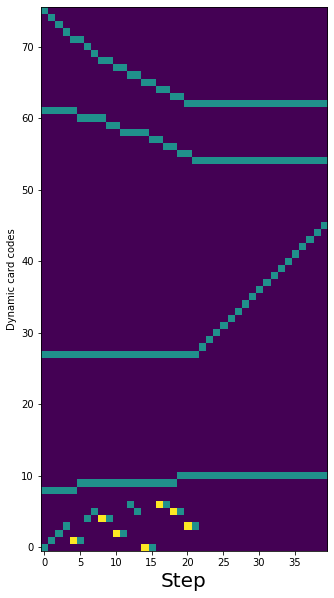

In [22]:
plt.figure(figsize=(20,10))
plt.xlabel('Step', fontsize=20)
plt.ylabel('Dynamic card codes')
plt.imshow(image, origin='lower')

In [23]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = keras.models.Model(inputs=model.input, outputs=layer_outputs)
img = image.reshape(image.shape[0], image.shape[1], 1)
img_tensor = np.expand_dims(img, axis=0)
img_tensor /= 255.

activations = activation_model.predict(img_tensor) 

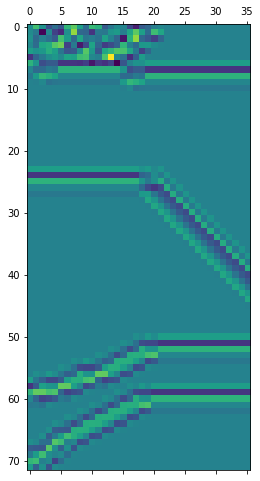

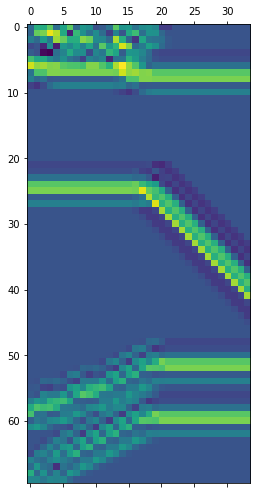

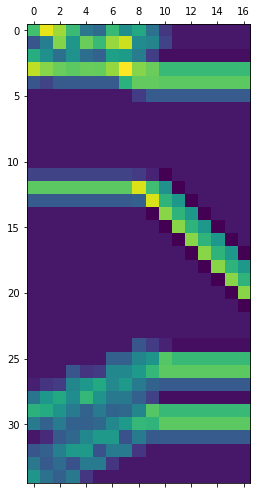

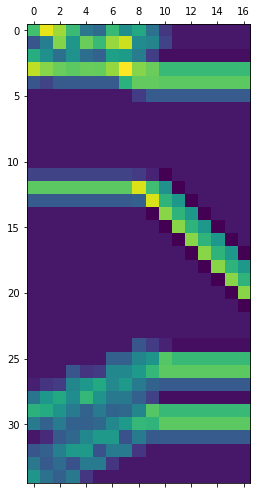

In [71]:
for l in range(4,5):
    for i in range(4):
        layer_activation = activations[i]
        plt.matshow(layer_activation[0, :, :, l], cmap='viridis')

([], <a list of 0 Text yticklabel objects>)

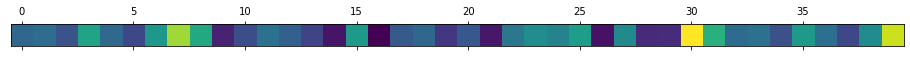

In [61]:
first_layer_activation = activations[4]
#plt.matshow(first_layer_activation[0], cmap='viridis')##
first_layer_activation = np.expand_dims(first_layer_activation, axis=0)
first_layer_activation = first_layer_activation[:, :, :40]
first_layer_activation.shape
plt.matshow(first_layer_activation[0, :, :], cmap='viridis')
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

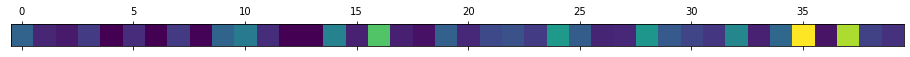

In [62]:
first_layer_activation = activations[5]
#plt.matshow(first_layer_activation[0], cmap='viridis')##
first_layer_activation = np.expand_dims(first_layer_activation, axis=0)
first_layer_activation = first_layer_activation[:, :, :40]
first_layer_activation.shape
plt.matshow(first_layer_activation[0, :, :], cmap='viridis')
plt.yticks([])


([], <a list of 0 Text yticklabel objects>)

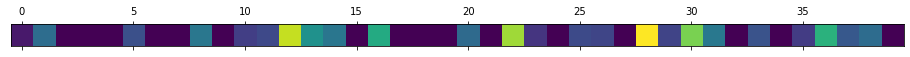

In [63]:
first_layer_activation = activations[6]
#plt.matshow(first_layer_activation[0], cmap='viridis')##
first_layer_activation = np.expand_dims(first_layer_activation, axis=0)
first_layer_activation = first_layer_activation[:, :, :40]
first_layer_activation.shape
plt.matshow(first_layer_activation[0, :, :], cmap='viridis')
plt.yticks([])

([], <a list of 0 Text yticklabel objects>)

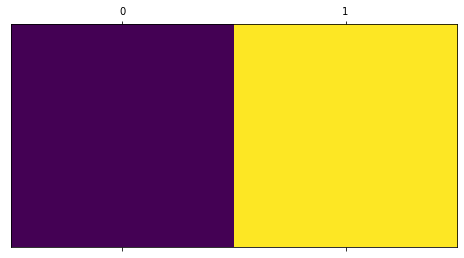

In [64]:
first_layer_activation = activations[7]
#plt.matshow(first_layer_activation[0], cmap='viridis')##
first_layer_activation = np.expand_dims(first_layer_activation, axis=0)
first_layer_activation = first_layer_activation[:, :, :40]
first_layer_activation.shape
plt.matshow(first_layer_activation[0, :, :], cmap='viridis')
plt.yticks([])